# Introduksjon til beslutningstrær
## Tre-struktur
Beslutningstrær er en type trær som representerer et sett med spørsmål. I maskinlærings-sammenheng ønsker vi vanligvis å bruke beslutningstrær for å estimere en størrelse eller en egenskap. Bildet under viser et veldig enkelt eksempel på hvordan vi kan klassifisere dyr basert på spørsmål om vekt, antall bein, og høyde:

<img src="Example_simple_decision_tree.png" alt="Drawing" style="width: 450px;"/>

I eksempelet over er vekt, antall bein og høyde eksempler på "features" som beskriver ulike dyr, mens dyrearten er en kategori eller "klasse" som skal bestemmes. 

Et beslutningstre består av to typer noder: gren-noder ("decision nodes"), som representerer spørsmål, og løvnoder ("terminal nodes") som tilsvarer en kategori. Bildet under illustrerer dette:

<img src="https://cdn-images-1.medium.com/v2/resize:fit:688/0*pb-1ufHK-OmR8k7r.png" alt="Drawing" style="width: 600px;"/>

(bilde hentet fra https://towardsai.net/p/programming/decision-trees-explained-with-a-practical-example-fe47872d3b53 )

Rot-noden er øverst i treet og tilsvarer første spørsmål som stilles. I figuren har rotnoden farget blå, men den er en gren-node ("decision node") på lik linje med de andre i treet.

In [1]:
# Imports
import numpy as np
import sklearn.datasets
import sklearn.inspection
import matplotlib.pyplot as plt

import supervised_learning as sl

## Eksempel-datasett
For å illustrere konseptene knyttet til beslutningstrær skal vi bruke datasett bestående av en matrise $X$ og en vektor $y$. Matrisen $X$ inneholder alle våre observasjoner. Hver rad tilsvarer en observasjon, eller et "sample", og hver kolonne tilsvarer en type observasjon, eller "feature". Vektoren y tilsvarer størrelsen vi ønsker å estimere basert på observasjonene i $X$. 

I denne oppgaven skal vi holde oss til klassifisering. Det vil si at y-verdiene våre tilsvarer _kategorier_ eller _klasser_ (Obs: I denne sammenhengen betyr _klasse_ noe annet enn i objekorientert programmering). Vi bruker heltall 0, 1, 2, ... som numeriske "merkelapper" på klassene våre. Vi bruker en hjelpefunksjon fra Scikit-Learn for å generere et sett syntetiske data med 4 klasser.  

In [2]:
# Create clusters of 2D data points with Gaussian distribution
centers = np.array([[-1, 0],
                     [1, 1],
                     [0.5, -1],
                     [1.5, -1]])
X,y = sklearn.datasets.make_blobs(centers=centers,
                                  cluster_std=np.array([0.4, 0.4, 0.2, 0.2]),
                                  n_samples = np.array([50, 30, 15, 15]),
                                  random_state=42)

Vi skriver ut $X$ og $y$ for å se hvordan de er strukturert som 2D og 1D NumPy-array:

In [3]:
print(f'{X=}')
print(f'{y=}')

X=array([[ 1.53463619, -0.92293652],
       [-0.99795462, -0.09383485],
       [-0.90321509, -0.7653121 ],
       [ 1.22446613, -1.18756501],
       [ 0.44706863, -0.45596617],
       [ 1.54281875, -1.24914776],
       [-0.85534559, -0.2580479 ],
       [ 0.50521972,  0.47181735],
       [ 1.40292729, -0.98362517],
       [ 1.09098397,  1.5228571 ],
       [-0.67098204, -0.48833746],
       [-1.2707688 ,  0.24467052],
       [ 0.33064126, -1.30296944],
       [ 0.48457966, -0.93176961],
       [-0.41374049, -0.09031052],
       [-0.63383915,  0.13150044],
       [ 0.30506367, -0.84258308],
       [-1.1916697 , -0.07426359],
       [-2.04789804,  0.328761  ],
       [-1.32339744, -0.20070282],
       [-1.44253399, -0.47848265],
       [ 0.66441203, -0.6206414 ],
       [ 0.59464752, -1.01456578],
       [-1.18425551,  0.42284889],
       [ 0.57507851,  1.18943697],
       [ 1.71661025, -0.78923959],
       [ 1.7463098 ,  1.18953317],
       [-1.08786876,  0.14284503],
       [ 0.6866986

Det er vanskelig å få noe begrep om sammenhengen mellom punktene og de ulike klassene de tilhører bare ved å se på tallene. Vi definerer en hjelpefunksjon som kan plotte hver observasjon som et punkt, med fargekoding av de ulike klassene.

In [4]:
def scatter_plot_2d_features(X,y,y_min=0,y_max=3,newfig=True):
    """ Visualize 2D features X and class label y as scatter plot
    
    # Arguments:
    X:    NumPy array with features. Shape (n_samples,2)
    y:    NumPy array with integer class labels. Shape (n_samples,)
    
    # Keyword arguments:
    y_min:   Minimum value for class label (usually zero) 
    y_max:   Maximum value for class label (usually n_classes-1)
    
    # Notes:
    y_min and y_max are useful in cases where you want to plot _parts_
    of the dataset which don't contain all class labels. Setting
    y_min and y_max will help keep class colors consistent. If you're 
    plotting the whole dataset, you don't need to set these.
    """
    if newfig:
        fig = plt.figure(figsize=(5,3.5))
    for label_value in np.unique(y):
        plt.scatter(x=X[y==label_value,0],
                    y=X[y==label_value,1],
                    c=y[y==label_value],
                    label=f'Class {label_value}',
                    vmin=y_min,
                    vmax=y_max)    
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.legend()
    

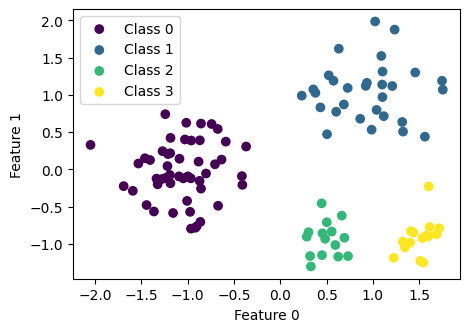

In [5]:
# Plot the dataset
scatter_plot_2d_features(X,y)

## Gini impurity
Du skal etterhvert lage byggeblokkene til din egen implementasjon av et beslutningstre. Det finnes flere varianter av slike trær, men i vårt tilfelle skal vi begrense oss til binære trær der alle features er numeriske (ikke kategorier), og der alle spørsmål kan stilles på formen "er feature $f_j$ <= verdi $v$?". Når vi har et ferdig bygget beslutningstre, kan vi mate inn nye observasjoner (dvs. en ny X-matrise) og få treet til å klassifisere disse.  

Men først må vi altså bygge treet, basert på et sett treningsdata $X$ der vi kjenner klassene $y$. For at treet skal fungere effektivt og ikke bli alt for stort, er vi nødt til å velge "gode spørsmål". Et godt spørsmål i denne sammenhengen er et spørsmål som deler datasettet i to deler ("venstre" og "høyre") på en måte som gjør delene "renere". Vi kan ta datasettet vi har generert som eksempel: Hvis vi bruker spørsmålet "feature 0 <= 0.0 ?" vil svaret være sant for alle punktene i klasse 0. Disse punktene utgjør da "venstre" del av splitten. Svaret er usant for klasse 1-3, som utgjør høyre del av splitten. Siden venstre del består av kun én klasse, er den 100% "ren". Høyre del består av 3 klasser, og selv om den ikke er 100% ren, er den _renere_, siden den inneholder færre klasser enn datasettet vi startet med.

For å kunne komme videre med dette trenger vi en matematisk definisjon av "renhet". I denne oppgaven bruker vi "Gini impurity", som også kalles "Gini index". For å forstå Gini impurity kan man tenke seg at man har et datasett med flere ulike klasser, og at antallet forekomster av hver klasse er ulikt. Hvis man trekker et datapunkt og klassifiserer dette med en tilfeldig klasse (av klassene som finnes i settet), angir Gini impurity sannsynligheten for at klassifiseringen blir _feil_. Vi kan se på noen spesialtilfeller:
- Dersom man har et datasett med kun 1 klasse, er det umulig å gi noen feil klassifisering, og Gini impurity blir 0. 
- Dersom man har et datasett med 2 klasser, med like mange observasjoner av hver, er sannsynligheten for feil klassifisering 50%. Gini impurity blir da 0.5.
- Dersom hver klasse er like sannsynlig og man øker antallet klasser, vil Gini impurity gå mot 1 ("uendelig" mange klasser gir 100% sannsynlighet for feil klassifisering)

Gini impurity er definert som

$$I_G = 1 - \sum_{i=0}^{J-1}p_i^2$$ 

der $J$ er antallet klasser og $p_i$ er sannsynligheten for å tilfeldig velge klasse $i$. Hvis vi for eksempel har 3 klasser som utgjør 50%, 30% og 20% av datasettet, vil vi ha $p_0 = 0.5$, $p_1 = 0.3$ og $p_2 = 0.2$, og Gini impurity blir 

$$I_G = 1 - 0.5^2 - 0.3^2 - 0.2^2 = 0.62$$ 

**Oppgave: Du skal selv implementere en funksjon som beregner Gini impurity** (se startkode i supervised_lerning.py)

## Finne gjennomsnittelig reduksjon i Gini impurity ved splitt
Vi kan ta utgangspunkt i spørsmålet "er feature 0 <= 0.0" som et eksempel på et spørsmål som splitter datasettet. Man sjekker da om dette er oppfylt eller ikke for alle radene i X, og resultatet blir en Boolsk vektor med True der feature 0 <=0.0, og False ellers.

In [6]:
left_mask = (X[:,0] <= 0.0)
print(left_mask)

[False  True  True False False False  True False False False  True  True
 False False  True  True False  True  True  True  True False False  True
 False False False  True False  True  True  True  True  True False  True
  True  True False  True False False False False False False False False
  True  True False False  True False False  True False  True False  True
 False False False  True False False False  True  True False False  True
  True  True  True False False False False False  True  True  True  True
  True False  True False  True  True False  True False False  True False
 False  True False  True False  True False False False  True False False
 False  True]


Vi deler opp datasettet vårt i en "left" og "right" del:

In [7]:
X_left = X[left_mask,:]
y_left = y[left_mask]
X_right = X[~left_mask,:]
y_right = y[~left_mask]
print(f'y vector value for left split: {y_left}')
print(f'y vector value for right split: {y_right}')

y vector value for left split: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
y vector value for right split: [3 3 2 3 1 3 1 2 2 2 2 2 1 3 1 1 1 1 3 1 1 1 2 2 2 1 2 1 1 1 1 1 3 2 1 1 2
 3 1 1 3 2 3 2 3 3 1 1 3 1 1 1 1 1 2 3 3 1 1 1]


Vi legger merke til at spørsmålet vårt har delt datasettet i to deler der den ene kun tilsvarer klasse 0, og den andre tilsvarer en blanding av klasse 1, 2 og 3. Vi kan også vise dette ved å plotte begge deler:

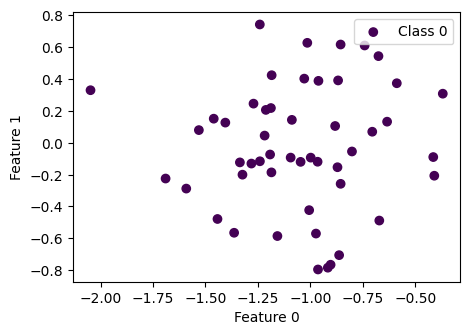

In [8]:
# Plot left dataset
scatter_plot_2d_features(X_left,y_left)

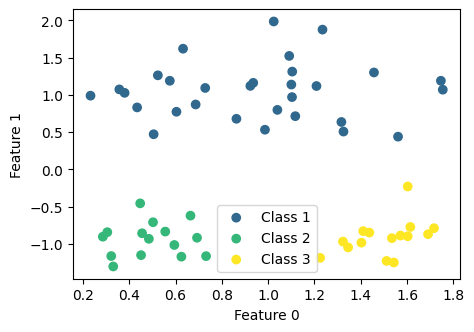

In [9]:
# Plot right dataset
scatter_plot_2d_features(X_right,y_right)

Vi ønsker altså å finne "gode spørsmål" som deler datasettet opp i gradvis "renere" smådeler. For å vurdere om et spørsmål er bedre enn et annet ser vi på hvor stor reduksjon i Gini impurity vi oppnår ved å dele datasettet i to. Vi må da først beregne Gini impurity før datasettet splittes, så beregne _gjennomsnittelig_ Gini impurity for de to delene etter splitting, og så beregne differansen mellom disse. Matematisk kan vi skrive

$$\Delta I_G = I_{G,\text{before}} - \hat{I}_{G,\text{after}}$$

Hvis vi bruker symbolene $N_{\text{left}}$ og $N_{\text{right}}$ for å angi antallet observasjoner i venstre og høyre del, og tilsvarende $I_{G,\text{left}}$ og tilsvarende $I_{G,\text{right}}$ for å angi Gini impurity i venstre og høyre del, kan vi uttrykke reduksjonen i Gini impurity som

$$\Delta I_G =  I_{G,\text{before}} - \frac{N_{\text{left}} \cdot I_{G,\text{left}} + N_{\text{right}} \cdot I_{G,\text{right}}}{N_{\text{left}}+N_{\text{right}}}$$

I vårt tilfelle er fordelingen på klasser i det opprinnelige datasettet 50, 30, 15 og 15, for henholdsvis klasse 0, 1, 2 og 3. Etter vår eksempel-splitt har vi et datasett med kun klasse 0 (50 av 50 observasjoner), og et datasett med 30, 15 og 15 samples fordelt på klasse 1, 2 og 3. Vi regner ut reduksjonen i gjennomsnittelig Gini impurity: 

$I_{G,\text{before}} = 1 - (50/110)^2 - (30/110)^2 - (15/110)^2 - (15/110)^2 = 0.6818$ \
$I_{G,\text{left}} = 1 - (50/50)^2 = 0$ \
$I_{G,\text{right}} = 1 - (30/60)^2 - (15/60)^2 - (15/60)^2 = 0.625$ \
$\Delta I_G =  0.642 - \frac{50 \cdot 0 + 60 \cdot 0.625}{50+60} = 0.3409$

Med våre eksempel-tall ser vi at gjennomsnittelig $I_G$ reduseres til halvparten av det det var i det opprinnelige datasettet. 

In [10]:
GI_whole = 1-(50/110)**2 - (30/110)**2 - (15/110)**2 - (15/110)**2
GI_left = 1 - (50/50)**2
GI_right = 1 - (30/60)**2 - (15/60)**2 - (15/60)**2
GI_mean = (50*GI_left + 60*GI_right)/(50+60)
delta_GI = GI_whole - GI_mean

print(f'GI before split:{GI_whole}')
print(f'GI left split:{GI_left}')
print(f'GI right split:{GI_right}')
print(f'Mean GI after split:{GI_mean}')
print(f'Reduction in GI by split:{delta_GI}')

GI before split:0.6818181818181819
GI left split:0.0
GI right split:0.625
Mean GI after split:0.3409090909090909
Reduction in GI by split:0.340909090909091


**Oppgave: Du skal implementere en funksjon som beregner gjennomsnittelig reduksjon i GI ved splitt** (se startkode i supervised_learning.py)

In [11]:
# Calculate reduction in Gini impurity
GI_reduction = sl.gini_impurity_reduction(y,left_mask)
print(f'GI reduction calculated by function: {GI_reduction}')

GI reduction calculated by function: 0.340909090909091


## Finne beste spørsmål basert på høyeste reduksjon i Gini impurity
I eksempelet over valgte vi feature 0 og verdien 0.0 for å lage et spørsmål som splittet datasettet. Når vi skal konstruere et beslutningstre trenger vi en metode som velger "beste spørsmål" (dvs. kombinasjon av feature og verdi) automatisk. Vi definerer beste spørsmål som det spørsmålet som gir høyest reduksjon i Gini impurity når datasettet splittes. 

For å finne det beste spørsmålet, tar vi utgangspunkt i alle de unike verdiene som allerede finnes i X-matrisa, og lager spørsmål basert på disse. Vi tar vare på feature index (0,1,...) og verdi for spørsmålet som gir høyest reduksjon i Gini impurity. Pseudokoden under viser hvordan man kan gjøre det:

    question_feature_index = None
    question_value = None 
    best_GI_reduction = (-infinity)
    for every feature (every column) f with index j in X:
        for every value in set of unique values in feature f_j:
            let left_mask equal (f_j <= value)
            GI_reduction = gini_impurity_reduction(y,left_mask)
            if GI_reduction > best_GI_reduction:
                 best_GI_reduction = GI_reduction
                 question_feature_index = j
                 question_value = value

I koden under sjekker vi manuelt hvilken GI-reduksjon man får for ulike kombinasjoner av features og verdier. Du må selv implementere pseudokoden over for å søke etter beste spørsmål.

In [12]:
# Check every combination of first feature
for value in np.unique(X[:,0]):
    left_mask = (X[:,0] <= value)
    gi_reduction = sl.gini_impurity_reduction(y,left_mask)
    print(f'"Feature 0 <= {value}" question: GI reduction of {gi_reduction}')

"Feature 0 <= -2.047898041635898" question: GI reduction of 0.0037531276063388352
"Feature 0 <= -1.6899671330052133" question: GI reduction of 0.00757575757575768
"Feature 0 <= -1.591408796146971" question: GI reduction of 0.011469838572642388
"Feature 0 <= -1.5312744195593724" question: GI reduction of 0.015437392795883409
"Feature 0 <= -1.4603974309689212" question: GI reduction of 0.019480519480519543
"Feature 0 <= -1.4425339896024112" question: GI reduction of 0.02360139860139865
"Feature 0 <= -1.4051324481337695" question: GI reduction of 0.027802294792586113
"Feature 0 <= -1.3632096302084844" question: GI reduction of 0.03208556149732633
"Feature 0 <= -1.3356870092890554" question: GI reduction of 0.03645364536453655
"Feature 0 <= -1.323397441157275" question: GI reduction of 0.040909090909090895
"Feature 0 <= -1.280821237550941" question: GI reduction of 0.045454545454545636
"Feature 0 <= -1.2707688001223836" question: GI reduction of 0.05009276437847876
"Feature 0 <= -1.2406826

In [13]:
# Check every combination of second feature
for value in np.unique(X[:,1]):
    left_mask = (X[:,1] <= value)
    gi_reduction = sl.gini_impurity_reduction(y,left_mask)
    print(f'"Feature 1 <= {value}" question: GI reduction of {gi_reduction}')

"Feature 1 <= -1.302969444937173" question: GI reduction of 0.009591326105087727
"Feature 1 <= -1.2491477557423976" question: GI reduction of 0.010101010101010277
"Feature 1 <= -1.2285940595661247" question: GI reduction of 0.016850750495610356
"Feature 1 <= -1.1875650079830247" question: GI reduction of 0.025300171526586812
"Feature 1 <= -1.1714315112832565" question: GI reduction of 0.02692640692640691
"Feature 1 <= -1.1641364636703422" question: GI reduction of 0.03146853146853157
"Feature 1 <= -1.1631620569930876" question: GI reduction of 0.03776320766612029
"Feature 1 <= -1.150747232871498" question: GI reduction of 0.04523172905525852
"Feature 1 <= -1.0473637213480018" question: GI reduction of 0.049154915491549156
"Feature 1 <= -1.0145657825313745" question: GI reduction of 0.056545454545454676
"Feature 1 <= -0.9836251721227355" question: GI reduction of 0.06106519742883376
"Feature 1 <= -0.9692549788108944" question: GI reduction of 0.06679035250463816
"Feature 1 <= -0.9317696

**Oppgave: Du skal implementere en funksjon som sjekker alle potensielle spørsmål basert på unike verdier i X-matrisa, og returnerer det beste spørsmålet.** (se startkode i supervised_learning.py)

Beste mulige reduksjon i GI hvis man bruker feature 0 er 0.3409, og beste reduksjon i GI hvis man bruker feature 1 er 0.2238. Spørsmålet "er feature 0 <= -0.3683" er det beste spørsmålet man kan stille av alle kandidatene vi har testet. Treet bør starte med en gren-node basert på dette beste spørsmålet. Siden dette er den første noden, er den også rot-noden.

Koden for å bygge treet er allerede implementer i supervised_learning.py. Metoden prøver å splitte datasettet i to. Dersom det er mulig å redusere GI ved en slik splitt, opprettes en gren-node basert på spørsmålet som splittet datasettet. Hvis det ikke er mulig, opprettes en løvnode som representerer en klasse. Vi viser her hvordan treet blir seende ut etter ferdig trening på datasettet over: 

In [14]:
decision_tree = sl.DecisionTree()
decision_tree.fit(X,y)
print(decision_tree)


  f0 <= -0.368_____________________
 /                                 \
0                       _______f1 <= -0.229
                       /                   \
                 f0 <= 0.732                1
                /           \
               2             3



Vi kan visualisere spørsmålene i beslutningstreet som vertikale og horisontale streker i et plott:

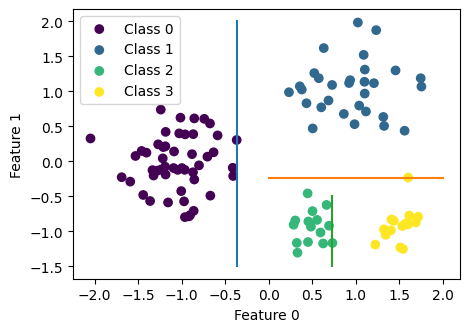

In [15]:
scatter_plot_2d_features(X,y)
plt.plot([decision_tree._root.feature_value]*2,[-1.5,2])
plt.plot([0,2],[decision_tree._root.right.feature_value]*2)
plt.plot([decision_tree._root.right.left.feature_value]*2,[-1.5,-0.5])
plt.show()

Vi kan se at våre spørsmål deler opp datasettet i fire deler der hver del kun inneholder en klasse. Snedig!

Vi kan også bruke en ferdig funksjon fra (sklearn.inspection.DecisionBoundaryDisplay) for å visualisere hvordan de ulike områdene klassifiseres. Denne kan også du bruke senere for å sjekke hvordan din implementasjon av beslutningstre fungerer.

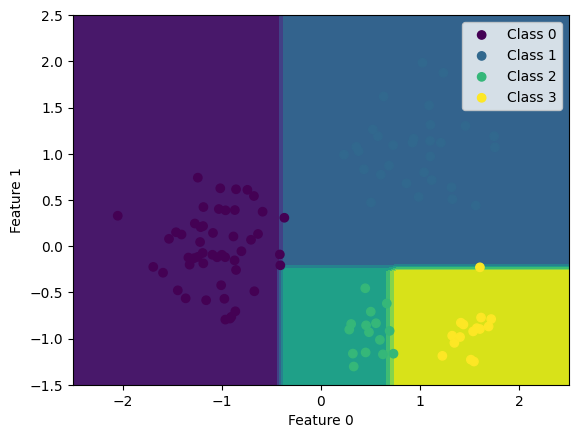

In [16]:
# Show the decision boundaries of the decision tree
feature_1, feature_2 = np.meshgrid(np.linspace(start=-2.5,stop=2.5),
                                       np.linspace(start=-1.5,stop=2.5))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
y_pred = np.reshape(decision_tree.predict(grid), feature_1.shape)
display = sklearn.inspection.DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()
scatter_plot_2d_features(X,y,newfig=False)
plt.show()